<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

**Задача**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нужно модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**План работы:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

## Подготовка

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv')
except:
    df = pd.read_csv(r"C:\Users\Markm\Downloads\taxi.csv")

In [3]:
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
#изменим типа данных столбца datetime на datetime64
df['datetime'] = df['datetime'].astype('datetime64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [5]:
#сделаем столбец с датой индексом таблицы
df = df.set_index('datetime')
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
#проверим, в хронологическом ли порядке расположены даты и время
df.index.is_monotonic

True

In [7]:
#выаолним ресемплирование данных по одному часу, возьмем среднее за час
df = df.resample('1H').sum()
df.head()

#df.plot()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

In [8]:
df.sort_index(inplace=True)
display(df.head(1))
df.tail(1)


,num_orders
datetime,
2018-03-01,124


,num_orders
datetime,
2018-08-31 23:00:00,205


Мы видим, что у нас имеются данные за период 00:00:00 2018-03-01 до 23:00:00 2018-08-31. Получается, имеем данные с 1 марта по 31 августа 2018 года.

In [9]:
#проверим наличие пропущенных значений
df.isna().sum()

num_orders    0
dtype: int64

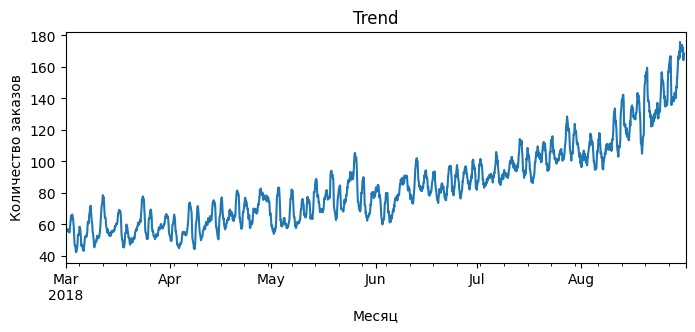

In [10]:
#посомтрим на тренд в нашем временном ряду
decomposed = seasonal_decompose(df)
plt.figure(figsize=(8, 3))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов');

Мы видим, что с марта по август количество заказов постепенно увеличивается каждый месяц.

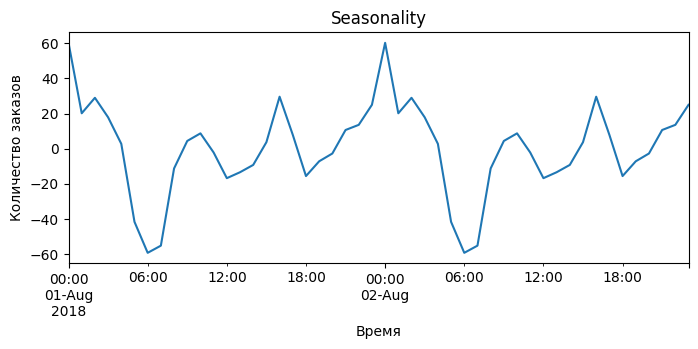

In [11]:
#посомтрим на сезонность в нашем временном ряду
plt.figure(figsize=(8, 3))
decomposed.seasonal['2018-08-01':"2018-08-02"].plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Время')
plt.ylabel('Количество заказов');

Мы видим, что количество заказов падает в утренние часы и увеличивается в ночное время. 

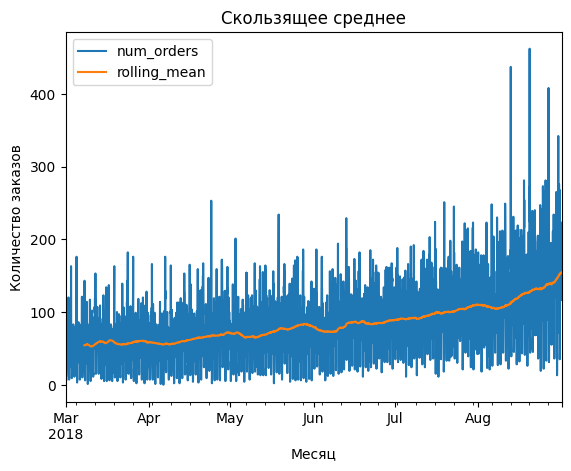

In [12]:
#создадим столбец со скользящим средним и отобразим его на графике
df['rolling_mean'] = df.rolling(168).mean()
df.plot()
plt.title('Cкользящее среднее')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов');

По скользящему среднему так же видим постепенное увеличение среднего количества заказов к августу.

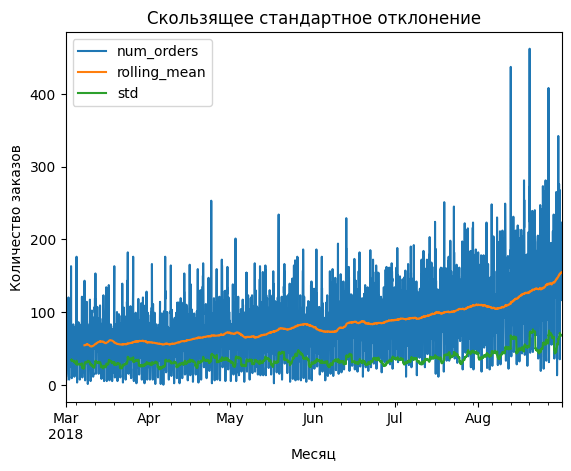

In [13]:
#найдем скользящее стандартное отклонение
df['std'] = df['num_orders'].rolling(50).std()
df.plot() 
plt.title('Скользящее стандартное отклонение')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов');

Временной ряд подходит для прогнозирования, скользящее среднее и скользящее стандартное отклонение невелики.

**Выводы**
1. Имеются данные с 1 марта по 31 августа 2018 года.
2. С  марта по август количество заказов постепенно увеличивается каждый месяц.
3. Количество заказов падает в утренние часы и увеличивается в ночное время. 

## Обучение

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
make_features(df, 24, 168)

In [15]:
df.head()

,num_orders,rolling_mean,std,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,2,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,4,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
#удалим из данных столбец std, который созадавался с учетом предсказываемого значения
df= df.drop('std', axis = 1)
df.head()

,num_orders,rolling_mean,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,2,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,4,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
#разделим данные на обучающую и тестовую выборки
train, test = train_test_split(df, test_size = 0.1, shuffle = False, random_state = 12)

In [18]:
#проверим, что данные разделены правильно
display(train.index.min(), train.index.max())
test.index.min(), test.index.max()

Timestamp('2018-03-01 00:00:00', freq='H')

Timestamp('2018-08-13 13:00:00', freq='H')

(Timestamp('2018-08-13 14:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

In [19]:
#Удалим пропущенные значения из обучающей выборки
train = train.dropna()

In [20]:
#созададим features и taarget в обучающей и тестовой выборках
train_features = train.drop('num_orders', axis = 1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis = 1)
test_target = test['num_orders']

In [21]:
model1 = Ridge(random_state = 12)
model2 = LGBMRegressor(random_state = 12)
model3 = CatBoostRegressor(random_state = 12)

In [22]:
param1 = {}
param1['solver']  = ['auto', 'lsqr', 'cholesky']
param1['alpha'] = [0.005, 0.02, 0.03, 0.05, 0.06]

param2={}
param2['max_depth'] = [ -1, 10, 20]
param2['n_estimators'] = [100,150, 200, 50]
#param2['num_leaves'] = [500, 50, 100]

param3 = {}
param3['iterations'] = [i for i in range(10, 15)]
param3['depth'] = [i for i in range(7, 10)]

In [23]:
 tscv = TimeSeriesSplit(n_splits=5)

In [24]:
#создадим функцию, которая принимает модель и набор гиперпараметров, подбирает гиперпараметры RandomSearchCV, на выходе выдает лучшие гиперпарамтеры и метрику rmse
def randomsearch(model, param):
    grid = RandomizedSearchCV(model, param, cv =tscv, scoring = 'neg_root_mean_squared_error', n_jobs = -1, random_state = 12, verbose = False).fit(train_features,train_target)
    return grid.best_params_, abs(grid.best_score_)

In [25]:
#посмотрим лучшие гиперпараметры и rmse для Ridge
randomsearch(model1, param1)

({'solver': 'auto', 'alpha': 0.06}, 27.07412395094907)

In [26]:
#посмотрим лучшие гиперпараметры и rmse для LGBMRegressor
randomsearch(model2, param2)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4812
[LightGBM] [Info] Number of data points in the train set: 3806, number of used features: 27
[LightGBM] [Info] Start training from score 79.352864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


({'n_estimators': 50, 'max_depth': 10}, 24.933332983539106)

In [27]:
#посмотрим лучшие гиперпараметры и rmse для CatBoostRegressor
randomsearch(model3, param3)

Learning rate set to 0.5
0:	learn: 29.9230065	total: 153ms	remaining: 1.83s
1:	learn: 26.6485940	total: 160ms	remaining: 881ms
2:	learn: 24.4072970	total: 168ms	remaining: 561ms
3:	learn: 23.5407515	total: 176ms	remaining: 395ms
4:	learn: 22.7079997	total: 183ms	remaining: 293ms
5:	learn: 22.1311089	total: 190ms	remaining: 222ms
6:	learn: 21.8002061	total: 199ms	remaining: 170ms
7:	learn: 21.7198395	total: 206ms	remaining: 129ms
8:	learn: 21.3854717	total: 213ms	remaining: 94.9ms
9:	learn: 21.0948919	total: 221ms	remaining: 66.2ms
10:	learn: 20.8287688	total: 228ms	remaining: 41.5ms
11:	learn: 20.5187630	total: 236ms	remaining: 19.6ms
12:	learn: 20.3345976	total: 243ms	remaining: 0us


({'iterations': 13, 'depth': 7}, 25.953473333411193)

**Выводы**
1. Модель LGBMRegressorс параметрами {'n_estimators': 50, 'max_depth': 10} показала метрику rmse 24.93.
2. Модель Ridge с гиперпараметрами {'solver': 'lsqr', 'alpha': 0.06} показала метрику rmse 26.97.
3. Модель CatBoostRegressor c гиперпараметрами {'iterations': 13, 'depth': 7} показала метрику rmse 25.95.
4. Лучшую метрику показала модель LGBMRegressor. Проведем ее тестирование на тестовой выборке. 

## Тестирование

In [28]:
model = LGBMRegressor(n_estimators = 50, max_depth = 10, random_state = 12)

In [29]:
model.fit(train_features, train_target)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4812
[LightGBM] [Info] Number of data points in the train set: 3806, number of used features: 27
[LightGBM] [Info] Start training from score 79.352864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor(max_depth=10, n_estimators=50, random_state=12)

In [30]:
pred = model.predict(test_features)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [31]:
rmse = mean_squared_error(test_target, pred, squared= False)
rmse

40.51407702077217

In [32]:
#проверим нашу модель на адекватность с помощью прогнозирования предыдущим значением, то есть количеством поездок за предыдущий час
pred_previous = test_target.shift()
pred_previous.iloc[0] = train_target.iloc[-1]

In [33]:
rmse_prev = mean_squared_error(test_target, pred_previous, squared = False)
rmse_prev

58.856486242815066

**Выводы**
1. Метрика RMSE нашей модели на тестовой выборке 40.5, что удовлетворяет условиям задачи.
2. Лучшая модель LGBMRegressor c гиперпараметрами max_depth = 10, n_estimators = 50.
3. Проверили модель на адекватность, rmse, полученная прогнозировнаием предыдущим значением - 58.85, что хуже, чем у нашей модели. Наша модель адекватна. 